### --- Імпорти та штуки необхідні для початку роботи

In [1]:
import zipfile
import os
import tarfile
os.environ['PROJ_LIB'] = r"C:\OSGeo4W\share\proj" # де шукати proj.db
import subprocess
import numpy as np
from osgeo import gdal
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import rasterio

#### Шляхи

In [2]:
sentinel_zip = "./lab7_data/lab 7 data.zip"
landsat_folder = "./lab7_data/landsat/"
output_dir = "lab7_data_unzipped"

### --- Функції для розпакування знімків Sentinel

In [3]:
def unpack(zip, output_dir):
    def win_path(path):
        path = os.path.abspath(path)
        if os.name == 'nt':
            if not path.startswith('\\\\?\\'):
                path = '\\\\?\\' + path
        return path

    # розпаковка основного архіву
    with zipfile.ZipFile(zip, 'r') as zip_ref:
        zip_ref.extractall(win_path(output_dir))

    # розпаковка вкладених архівів
    for item in os.listdir(output_dir):
        item_path = os.path.join(output_dir, item)
        if item.lower().endswith('.zip'):
            with zipfile.ZipFile(item_path, 'r') as zip_ref:
                zip_ref.extractall(win_path(output_dir))
            os.remove(item_path)
            print(f"Розпаковано Sentinel-2 архів: {item}")

    # перейменування .jp2 файлів
    for root, dirs, files in os.walk(output_dir):
        if 'IMG_DATA' in root:
            for file in files:
                if file.lower().endswith('.jp2'):
                    old_path = os.path.join(root, file)
                    parts = file.replace('.jp2', '').split('_')
                    if len(parts) >= 2:
                        new_name = '_'.join(parts[-2:]) + '.jp2'
                        new_path = os.path.join(root, new_name)

                        if old_path != new_path:
                            if os.path.exists(new_path):
                                os.remove(new_path)
                                print(f"Старий файл видалено: {new_name}")
                            os.rename(old_path, new_path)
                            print(f"Перейменовано: {file} -> {new_name}")

    print("Готово! Усі файли перейменовано.")

unpack(sentinel_zip, output_dir)

Розпаковано Sentinel-2 архів: S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip
Розпаковано Sentinel-2 архів: S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip
Перейменовано: T36UUA_20190821T085601_AOT_10m.jp2 -> AOT_10m.jp2
Перейменовано: T36UUA_20190821T085601_B02_10m.jp2 -> B02_10m.jp2
Перейменовано: T36UUA_20190821T085601_B03_10m.jp2 -> B03_10m.jp2
Перейменовано: T36UUA_20190821T085601_B04_10m.jp2 -> B04_10m.jp2
Перейменовано: T36UUA_20190821T085601_B08_10m.jp2 -> B08_10m.jp2
Перейменовано: T36UUA_20190821T085601_TCI_10m.jp2 -> TCI_10m.jp2
Перейменовано: T36UUA_20190821T085601_WVP_10m.jp2 -> WVP_10m.jp2
Перейменовано: T36UUA_20190821T085601_AOT_20m.jp2 -> AOT_20m.jp2
Перейменовано: T36UUA_20190821T085601_B02_20m.jp2 -> B02_20m.jp2
Перейменовано: T36UUA_20190821T085601_B03_20m.jp2 -> B03_20m.jp2
Перейменовано: T36UUA_20190821T085601_B04_20m.jp2 -> B04_20m.jp2
Перейменовано: T36UUA_20190821T085601_B05_20m.jp2 -> B05_20m.jp2
Перейменовано: T36UUA_20190821

### --- Функції для розпакування знімків Landsat

In [4]:
def unpack_landsat(landsat_folder, output_dir):
    def win_path(path):
        path = os.path.abspath(path)
        if os.name == 'nt':
            if not path.startswith('\\\\?\\'):
                path = '\\\\?\\' + path
        return path

    for filename in os.listdir(landsat_folder):
        if filename.lower().endswith('.tar'):
            tar_path = os.path.join(landsat_folder, filename)
            archive_name = os.path.splitext(filename)[0]  # без .tar
            target_dir = os.path.join(output_dir, archive_name)

            os.makedirs(target_dir, exist_ok=True)
            print(f"Розпаковую архів: {filename} у {target_dir}")

            with tarfile.open(tar_path, 'r') as tar:
                tar.extractall(path=win_path(target_dir))
            
            # Перейменування файлів після розпаковки
            for root, dirs, files in os.walk(target_dir):
                for file in files:
                    old_path = os.path.join(root, file)
                    if 'T1_' in file:
                        # Відрізаємо все до і включно T1_
                        new_name = file.split('T1_', 1)[-1]
                        new_path = os.path.join(root, new_name)
                        if old_path != new_path:
                            if os.path.exists(new_path):
                                os.remove(new_path)
                                print(f"Старий файл видалено: {new_name}")
                            os.rename(old_path, new_path)
                            print(f"Перейменовано: {file} -> {new_name}")

    print("Готово! Усі архіви оброблено.")

unpack_landsat(landsat_folder, output_dir)

Розпаковую архів: LC08_L1TP_182025_20190830_20200826_02_T1.tar у lab7_data_unzipped\LC08_L1TP_182025_20190830_20200826_02_T1


C:\Users\blood\AppData\Local\Temp\ipykernel_19100\778893836.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=win_path(target_dir))


Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_ANG.txt -> ANG.txt
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B1.TIF -> B1.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B10.TIF -> B10.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B11.TIF -> B11.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B2.TIF -> B2.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B3.TIF -> B3.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B4.TIF -> B4.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B5.TIF -> B5.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B6.TIF -> B6.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B7.TIF -> B7.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B8.TIF -> B8.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_B9.TIF -> B9.TIF
Перейменовано: LC08_L1TP_182025_20190830_20200826_02_T1_MTL.json -> MTL.json
Перейменовано: LC08_L1TP_182025_20190830_

### --- Виконання завдання до знімків Sentinel:

#### Параметри необхідні для роботи зі знімками

In [5]:

scenes = [
    r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab7_data_unzipped\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE",
    r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab7_data_unzipped\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE"
]

kanal_names = ['B02', 'B03', 'B04', 'B08']
resolution = '10m'
clip_template = r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab7_data_unzipped\Kyiv_regions.shp"
out_dir_sent = r"./lab7_parsed/"
pyton_interpr = r"c:\Users\blood\OneDrive\Документы\KPI\AD\lab2\Scripts\python.exe"
path_merge_gdal = r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab2\Lib\site-packages\osgeo_utils\gdal_merge.py"


#### Виконання завдання зі знімками

In [6]:
os.makedirs(out_dir_sent, exist_ok=True)

for scene_path in scenes:
    scene_name = os.path.basename(scene_path)
    scene_output = os.path.join(out_dir_sent, scene_name, f"R{resolution}")
    os.makedirs(scene_output, exist_ok=True)

    granule_path = os.path.join(scene_path, 'GRANULE')
    granule_subfolder = os.listdir(granule_path)[0]
    r_path = os.path.join(granule_path, granule_subfolder, 'IMG_DATA', f'R{resolution}')

    kanal_files = []
    for kanal in kanal_names:
        for fname in os.listdir(r_path):
            if kanal in fname and resolution in fname:
                kanal_files.append(os.path.join(r_path, fname))
                break

    kanal_files.sort()

    if kanal_files:
        reprojected_kanal_files = []

        for kanal_file in kanal_files:
            kanal_basename = os.path.splitext(os.path.basename(kanal_file))[0]
            #  Перепроектування
            reprojected_kanal_path = os.path.join(scene_output, f"{kanal_basename}_4326.tif")
            cmd_warp = [
                'gdalwarp',
                '-s_srs', 'EPSG:32636',
                '-t_srs', 'EPSG:4326',
                kanal_file,
                reprojected_kanal_path
            ]
            result_warp = subprocess.run(cmd_warp)
            if result_warp.returncode == 0 and os.path.exists(reprojected_kanal_path):
                print(f'[+] Перепроектовано: {reprojected_kanal_path}')
                reprojected_kanal_files.append(reprojected_kanal_path)
            else:
                print(f'[-] Помилка при перепроекції: {kanal_file}')

        if reprojected_kanal_files:
            #  Конкатенація у один 4-канальний файл TIFF
            combined_path = os.path.join(scene_output, f"combined_4326.tif")
            cmd_merge = [
                pyton_interpr,
                path_merge_gdal,
                "-o", combined_path,
                "-separate"
            ] + reprojected_kanal_files

            result_merge = subprocess.run(cmd_merge)
            if result_merge.returncode == 0 and os.path.exists(combined_path):
                print(f'[+] Комбіновано: {combined_path}')

                # Обрізка за шаблоном
                clipped_path = os.path.join(scene_output, f"clipped.tif")
                cmd_clip = [
                    "gdalwarp",
                    "-cutline", clip_template,  
                    "-crop_to_cutline",
                    "-dstalpha",
                    combined_path,
                    clipped_path
                ]
                result_clip = subprocess.run(cmd_clip)
                if result_clip.returncode == 0 and os.path.exists(clipped_path):
                    print(f'[+] Обрізано: {clipped_path}')
                else:
                    print(f'[-] Помилка при обрізці: {combined_path}')
            else:
                print(f'[-] Помилка при обʼєднанні: {scene_path}')
        else:
            print(f'[-] Не вдалося перепроектувати канали для сцени: {scene_path}')
    else:
        print(f'[-] Не знайдено канали для сцени: {scene_path}')


[+] Перепроектовано: ./lab7_parsed/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE\R10m\B02_10m_4326.tif
[+] Перепроектовано: ./lab7_parsed/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE\R10m\B03_10m_4326.tif
[+] Перепроектовано: ./lab7_parsed/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE\R10m\B04_10m_4326.tif
[+] Перепроектовано: ./lab7_parsed/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE\R10m\B08_10m_4326.tif
[+] Комбіновано: ./lab7_parsed/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE\R10m\combined_4326.tif
[+] Обрізано: ./lab7_parsed/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE\R10m\clipped.tif
[+] Перепроектовано: ./lab7_parsed/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE\R10m\B02_10m_4326.tif
[+] Перепроектовано: ./lab7_parsed/S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE\R10m\B03_10m_4326.tif
[+] Перепроектовано: ./lab7_par

### --- Виконання завдання до знімків Landsat:

#### Попередні Налаштування

In [7]:
out_dir = r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab7_parsed"
scene_list = [
    r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab7_data_unzipped\LC08_L1TP_182025_20190830_20200826_02_T1",
    r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab7_data_unzipped\LC08_L1TP_182026_20190830_20200826_02_T1"
]
bands_rgb = {'B4': 'red', 'B3': 'green', 'B2': 'blue'}
band_pan = 'B8'
pansharpen_methods = ['nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos', 'average']

python_interpreter = r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab2\Scripts\python.exe"
gdal_pansharpen = r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab2\Lib\site-packages\osgeo_utils\gdal_pansharpen.py"
gdal_merge = r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab2\Lib\site-packages\osgeo_utils\gdal_merge.py"

#### Реалізація необхідних функцій

In [8]:
def run_command(cmd, msg=None):
    if msg:
        print(msg)
    subprocess.run(cmd, check=True)

def warp_band(input_file, output_file, resolution, label=None):
    run_command([
        'gdalwarp', '-overwrite',
        '-tr', str(resolution), str(resolution),
        '-r', 'cubic',
        input_file, output_file
    ], f"[+] Перепроектовано {label} до {resolution}м: {os.path.basename(output_file)}")

def merge_bands(band_files, output_file):
    run_command([
        python_interpreter, gdal_merge,
        '-separate', '-o', output_file
    ] + band_files, f"[+] Об'єднано в {os.path.basename(output_file)}")

def pansharpen(pan_file, rgb_file, output_dir):
    outputs = {}
    for method in pansharpen_methods:
        output_file = os.path.join(output_dir, f"pansharpen_{method}.tif")
        run_command([
            python_interpreter, gdal_pansharpen,
            '-r', method,
            '-b', '1', '-b', '2', '-b', '3',
            '-co', 'PHOTOMETRIC=RGB',
            pan_file, rgb_file, output_file
        ], f"[+] Паншарпнено методом {method}: {os.path.basename(output_file)}")
        outputs[method] = output_file
    return outputs

def find_band_files(scene_path, bands):
    found_files = {}
    for band in bands:
        for file in os.listdir(scene_path):
            if band in file and file.endswith('.TIF'):
                found_files[band] = os.path.join(scene_path, file)
                break
    return found_files

#### Основна обробка

In [9]:
os.makedirs(out_dir, exist_ok=True)

for scene_path in scene_list:
    scene_name = os.path.basename(scene_path)
    scene_output = os.path.join(out_dir, scene_name)
    os.makedirs(scene_output, exist_ok=True)
    print(f"\n[+] Обробка сцени: {scene_name}")

    # Пошук необхідних каналів
    band_files = find_band_files(scene_path, list(bands_rgb.keys()) + [band_pan])
    if len(band_files) != 4:
        print(f"[-] Не всі потрібні канали знайдено у {scene_path}")
        continue

    # Підготовка референсного 30м RGB
    rgb_30m_dir = os.path.join(scene_output, 'RGB_30m_ref')
    os.makedirs(rgb_30m_dir, exist_ok=True)

    rgb_30m_files = [band_files[band] for band in bands_rgb.keys()]
    rgb_30m_merged = os.path.join(rgb_30m_dir, 'rgb_30m_merged.tif')
    merge_bands(rgb_30m_files, rgb_30m_merged)

    # 30м панхроматичний канал
    pan_30m_dir = os.path.join(scene_output, 'Pan_30m')
    os.makedirs(pan_30m_dir, exist_ok=True)

    pan_30m_file = os.path.join(pan_30m_dir, 'pan_30m.tif')
    warp_band(band_files[band_pan], pan_30m_file, resolution=30, label='pan')

    # Обробка 60м RGB каналів
    rgb_60m_dir = os.path.join(scene_output, 'RGB_60m')
    os.makedirs(rgb_60m_dir, exist_ok=True)

    rgb_60m_files = []
    for band, color in bands_rgb.items():
        output = os.path.join(rgb_60m_dir, f"{color}_60m.tif")
        warp_band(band_files[band], output, resolution=60, label=color)
        rgb_60m_files.append(output)


    # Злиття 60м RGB в одне зображення
    rgb_60m_merged = os.path.join(scene_output, 'rgb_60m_merged.tif')
    merge_bands(rgb_60m_files, rgb_60m_merged)

    # Паншарпенінг
    pansharpened_files = pansharpen(pan_30m_file, rgb_60m_merged, scene_output)

print("\n[+] Попередня обробка завершена! Можна переходити до обчислення метрик.")



[+] Обробка сцени: LC08_L1TP_182025_20190830_20200826_02_T1
[+] Об'єднано в rgb_30m_merged.tif
[+] Перепроектовано pan до 30м: pan_30m.tif
[+] Перепроектовано red до 60м: red_60m.tif
[+] Перепроектовано green до 60м: green_60m.tif
[+] Перепроектовано blue до 60м: blue_60m.tif
[+] Об'єднано в rgb_60m_merged.tif
[+] Паншарпнено методом nearest: pansharpen_nearest.tif
[+] Паншарпнено методом bilinear: pansharpen_bilinear.tif
[+] Паншарпнено методом cubic: pansharpen_cubic.tif
[+] Паншарпнено методом cubicspline: pansharpen_cubicspline.tif
[+] Паншарпнено методом lanczos: pansharpen_lanczos.tif
[+] Паншарпнено методом average: pansharpen_average.tif

[+] Обробка сцени: LC08_L1TP_182026_20190830_20200826_02_T1
[+] Об'єднано в rgb_30m_merged.tif
[+] Перепроектовано pan до 30м: pan_30m.tif
[+] Перепроектовано red до 60м: red_60m.tif
[+] Перепроектовано green до 60м: green_60m.tif
[+] Перепроектовано blue до 60м: blue_60m.tif
[+] Об'єднано в rgb_60m_merged.tif
[+] Паншарпнено методом nearest:

### --- Оцінка методів

#### Параметри

In [10]:
scene_output = r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab7_parsed\LC08_L1TP_182025_20190830_20200826_02_T1"  
ref_rgb_path = os.path.join(scene_output, 'RGB_30m_ref', 'rgb_30m_merged.tif')

#### Функції

In [11]:
def read_image_as_array(filepath):
    dataset = gdal.Open(filepath)
    if dataset is None:
        raise FileNotFoundError(f"Не вдалося відкрити файл: {filepath}")
    array = dataset.ReadAsArray()  # (bands, height, width)
    array = np.transpose(array, (1, 2, 0))  # (height, width, bands)
    return array

def calculate_metrics(reference_img, pansharpened_img):
    ref = reference_img.astype(np.float32)
    pan = pansharpened_img.astype(np.float32)

    # уникаємо порожніх пікселів якщо раптом десь
    valid_mask = (ref.sum(axis=2) > 0) & (pan.sum(axis=2) > 0)

    ref_valid = ref[valid_mask]
    pan_valid = pan[valid_mask]

    # Обчислення метрик
    mse = mean_squared_error(ref_valid, pan_valid)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(ref_valid, pan_valid)
    r2 = r2_score(ref_valid, pan_valid)

    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

#### Підготовка до оцінки

In [12]:
# Зчитування референсного RGB
reference_img = read_image_as_array(ref_rgb_path)
metrics_results = {}

for method in pansharpen_methods:
    pan_path = os.path.join(scene_output, f'pansharpen_{method}.tif')
    if not os.path.exists(pan_path):
        print(f"[!] Файл не знайдено для методу {method}: {pan_path}")
        continue

    pansharpened_img = read_image_as_array(pan_path)
    
    # Перевірка однакового розміру
    if reference_img.shape != pansharpened_img.shape:
        print(f"[!] Розмір не співпадає для методу {method}. Пропуск...")
        continue

    # Обчислення метрик
    metrics = calculate_metrics(reference_img, pansharpened_img)
    metrics_results[method] = metrics
    print(f"[+] Метрики для {method}: {metrics}")


c:\Users\blood\OneDrive\Документы\KPI\AD\lab2\Lib\site-packages\osgeo\gdal.py:314: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


[+] Метрики для nearest: {'RMSE': np.float64(276.8886988710446), 'MAE': 215.77525329589844, 'R2': 0.9773734211921692}
[+] Метрики для bilinear: {'RMSE': np.float64(277.52836285233985), 'MAE': 215.54266357421875, 'R2': 0.9772444367408752}
[+] Метрики для cubic: {'RMSE': np.float64(275.3424430368482), 'MAE': 214.8871307373047, 'R2': 0.9775693416595459}
[+] Метрики для cubicspline: {'RMSE': np.float64(280.2157232606693), 'MAE': 216.4573974609375, 'R2': 0.9768319725990295}
[+] Метрики для lanczos: {'RMSE': np.float64(274.46383812353133), 'MAE': 214.59912109375, 'R2': 0.9777037501335144}
[+] Метрики для average: {'RMSE': np.float64(276.9186619072467), 'MAE': 215.4195556640625, 'R2': 0.9773319363594055}


#### Пошук найкращого методу

In [13]:

# 1. Збираємо значення для всіх метрик
rmse_values = np.array([metrics['RMSE'] for metrics in metrics_results.values()])
mae_values = np.array([metrics['MAE'] for metrics in metrics_results.values()])
r2_values = np.array([metrics['R2'] for metrics in metrics_results.values()])

methods_list = list(metrics_results.keys())

# 2. Нормалізація метрик
def normalize(values, invert=False):
    if np.max(values) == np.min(values):
        return np.zeros_like(values)
    normed = (values - np.min(values)) / (np.max(values) - np.min(values))
    return 1 - normed if invert else normed

# Інвертуємо RMSE та MAE при нормалізації, бо менше = краще, а краще зробити більше = краще, на мою думку
rmse_norm = normalize(rmse_values, invert=True)
mae_norm = normalize(mae_values, invert=True)
r2_norm = normalize(r2_values, invert=False)

# 3. Задаємо вагу для кожної метрики
weight_rmse = 0.333
weight_mae = 0.333
weight_r2 = 0.333

# 4. Обчислюємо загальний скор для кожного методу
scores = weight_rmse * rmse_norm + weight_mae * mae_norm + weight_r2 * r2_norm

# 5. Пошук найкращого методу
best_idx = np.argmax(scores)
best_method = methods_list[best_idx]
best_score = scores[best_idx]


#### Вивід результатів

In [14]:
print("\n=== Підсумкові результати ===")
print(f"{'Метод':<12} {'RMSE':<10} {'MAE':<10} {'R2':<10}")
for method, metric in metrics_results.items():
    print(f"{method:<12} {metric['RMSE']:<10.4f} {metric['MAE']:<10.4f} {metric['R2']:<10.4f}")
print(f"\n[+] Найкращий метод паншарпнінгу: {best_method.upper()}")


=== Підсумкові результати ===
Метод        RMSE       MAE        R2        
nearest      276.8887   215.7753   0.9774    
bilinear     277.5284   215.5427   0.9772    
cubic        275.3424   214.8871   0.9776    
cubicspline  280.2157   216.4574   0.9768    
lanczos      274.4638   214.5991   0.9777    
average      276.9187   215.4196   0.9773    

[+] Найкращий метод паншарпнінгу: LANCZOS


### --- Графіки для наглядності

*** Чим менший RMSE і MAE тим краще, R² чим ближчий до 1 тим краще
*** Але RMSE і MAE інвертовані, тому всюди чим більше тим кращий метод


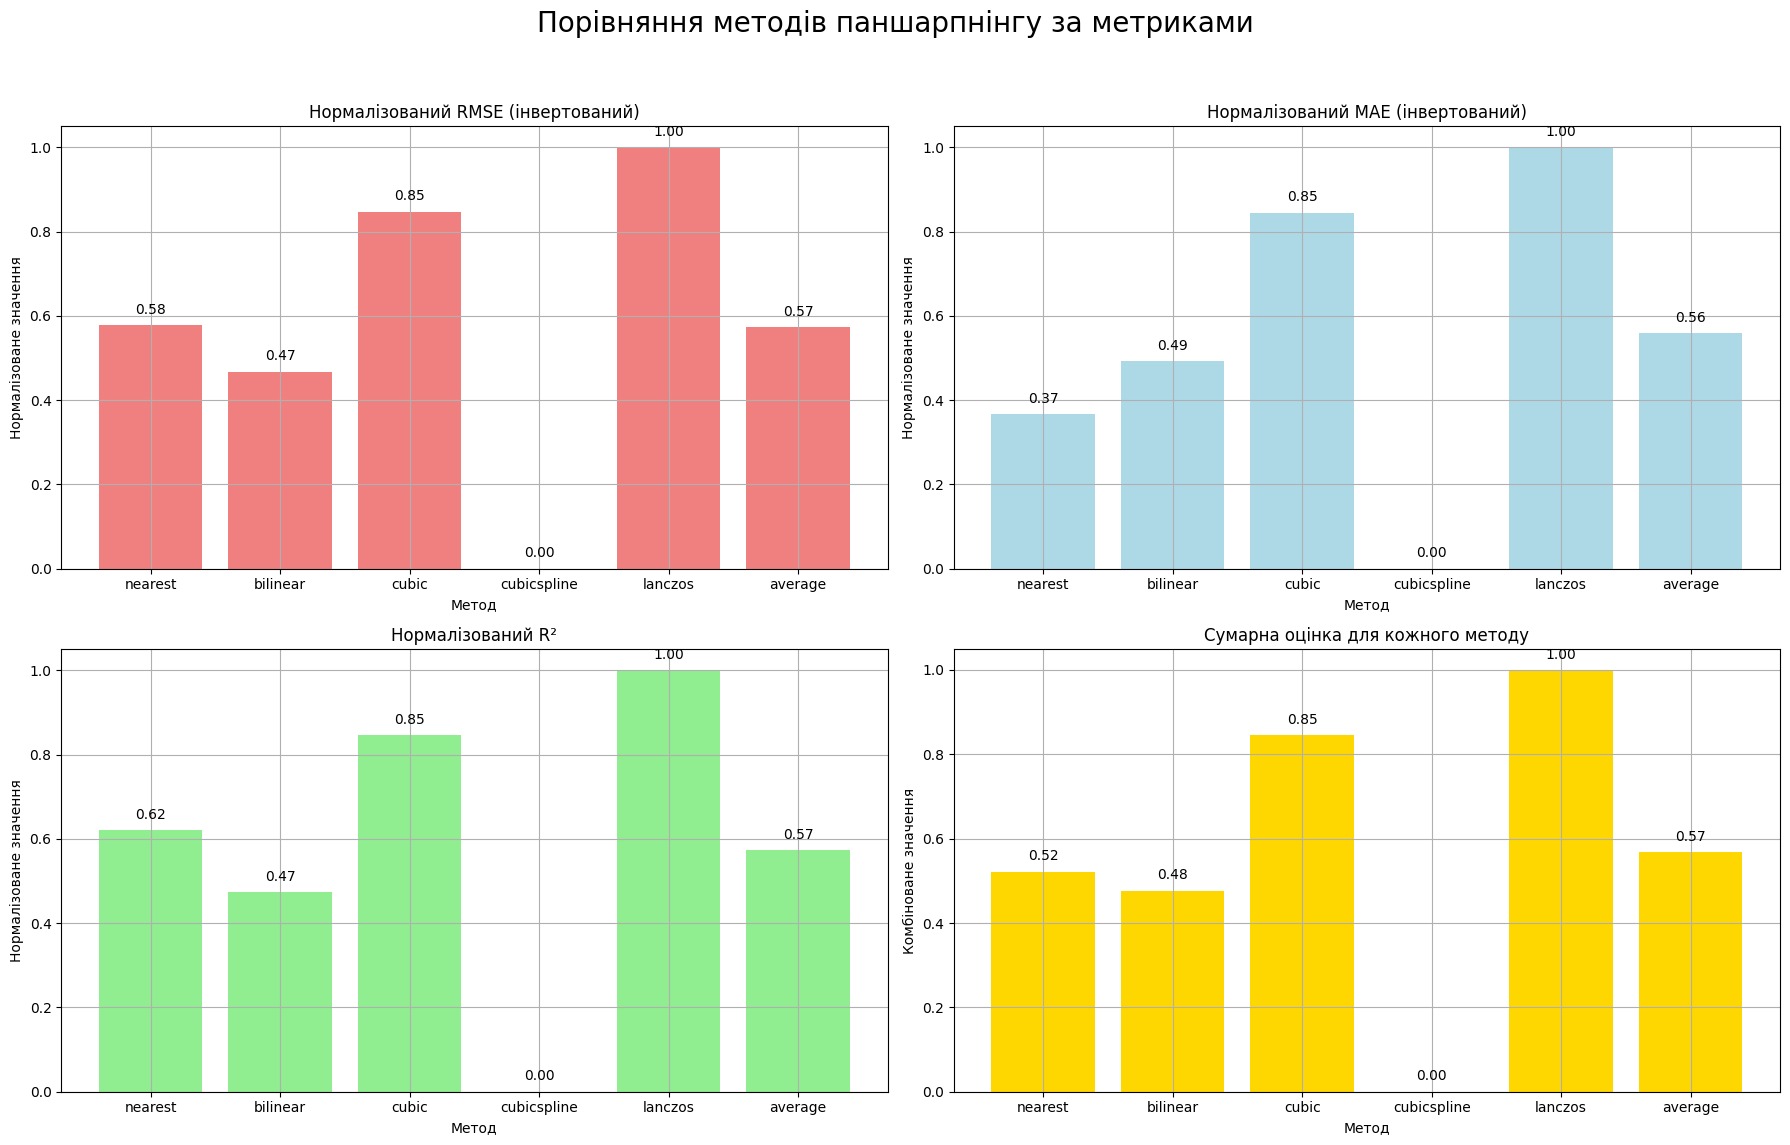

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(18, 12))

# Графік нормалізованого RMSE
ax[0, 0].bar(methods_list, rmse_norm, color='lightcoral')
ax[0, 0].set_title('Нормалізований RMSE (інвертований)')
ax[0, 0].set_xlabel('Метод')
ax[0, 0].set_ylabel('Нормалізоване значення')
ax[0, 0].grid(True)

# Графік нормалізованого MAE
ax[0, 1].bar(methods_list, mae_norm, color='lightblue')
ax[0, 1].set_title('Нормалізований MAE (інвертований)')
ax[0, 1].set_xlabel('Метод')
ax[0, 1].set_ylabel('Нормалізоване значення')
ax[0, 1].grid(True)

# Графік нормалізованого R²
ax[1, 0].bar(methods_list, r2_norm, color='lightgreen')
ax[1, 0].set_title('Нормалізований R²')
ax[1, 0].set_xlabel('Метод')
ax[1, 0].set_ylabel('Нормалізоване значення')
ax[1, 0].grid(True)

# Графік сумарного скору
ax[1, 1].bar(methods_list, scores, color='gold')
ax[1, 1].set_title('Сумарна оцінка для кожного методу')
ax[1, 1].set_xlabel('Метод')
ax[1, 1].set_ylabel('Комбіноване значення')
ax[1, 1].grid(True)

# Підписи зверху кожного стовпчика
for axis, values in zip(ax.flatten(), [rmse_norm, mae_norm, r2_norm, scores]):
    for idx, val in enumerate(values):
        axis.text(idx, val + 0.02, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

plt.suptitle('Порівняння методів паншарпнінгу за метриками', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
print("*** Чим менший RMSE і MAE тим краще, R² чим ближчий до 1 тим краще")
print("*** Але RMSE і MAE інвертовані, тому всюди чим більше тим кращий метод")
plt.show()


### --- Дивитися знімки

#### Функція для знімків

In [16]:
def show_image(image_path, rgb_indices=(1, 2, 3)):
    # Параметр rgb_indices дозволяє вказати які канали брати для RGB (1 2 3 відповідно)
    with rasterio.open(image_path) as src:
        img = src.read()

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.axis('off')

    if img.shape[0] == 1:
        ax.imshow(img[0], cmap='gray', aspect='equal')
    elif img.shape[0] >= 3:
        r = img[rgb_indices[0] - 1]
        g = img[rgb_indices[1] - 1]
        b = img[rgb_indices[2] - 1]
        rgb = np.stack((r, g, b), axis=-1)
        rgb_min = np.percentile(rgb, 2)
        rgb_max = np.percentile(rgb, 98)
        rgb = np.clip((rgb - rgb_min) / (rgb_max - rgb_min), 0, 1)
        ax.imshow(rgb, aspect='equal')
    else:
        raise ValueError("Невідомий формат знімка.")
    
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()


#### Обрізаний знімок Sentinel

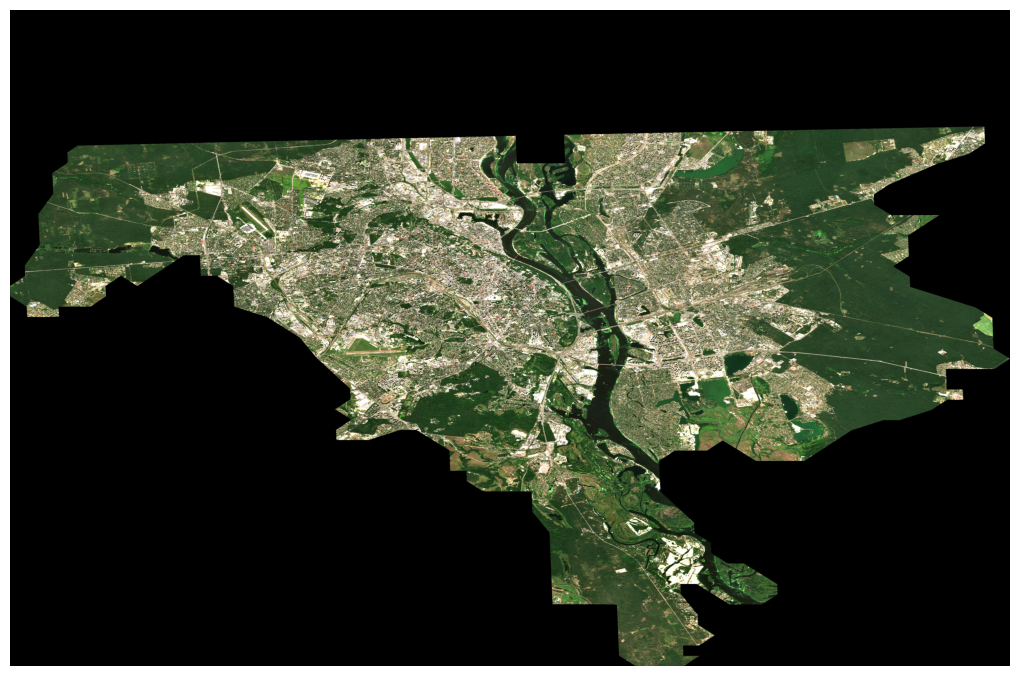

In [17]:
znimok_obrizan = r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab7_parsed\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE\R10m\clipped.tif"
show_image(znimok_obrizan, rgb_indices=(3, 2, 1))

#### Знімки Landsat

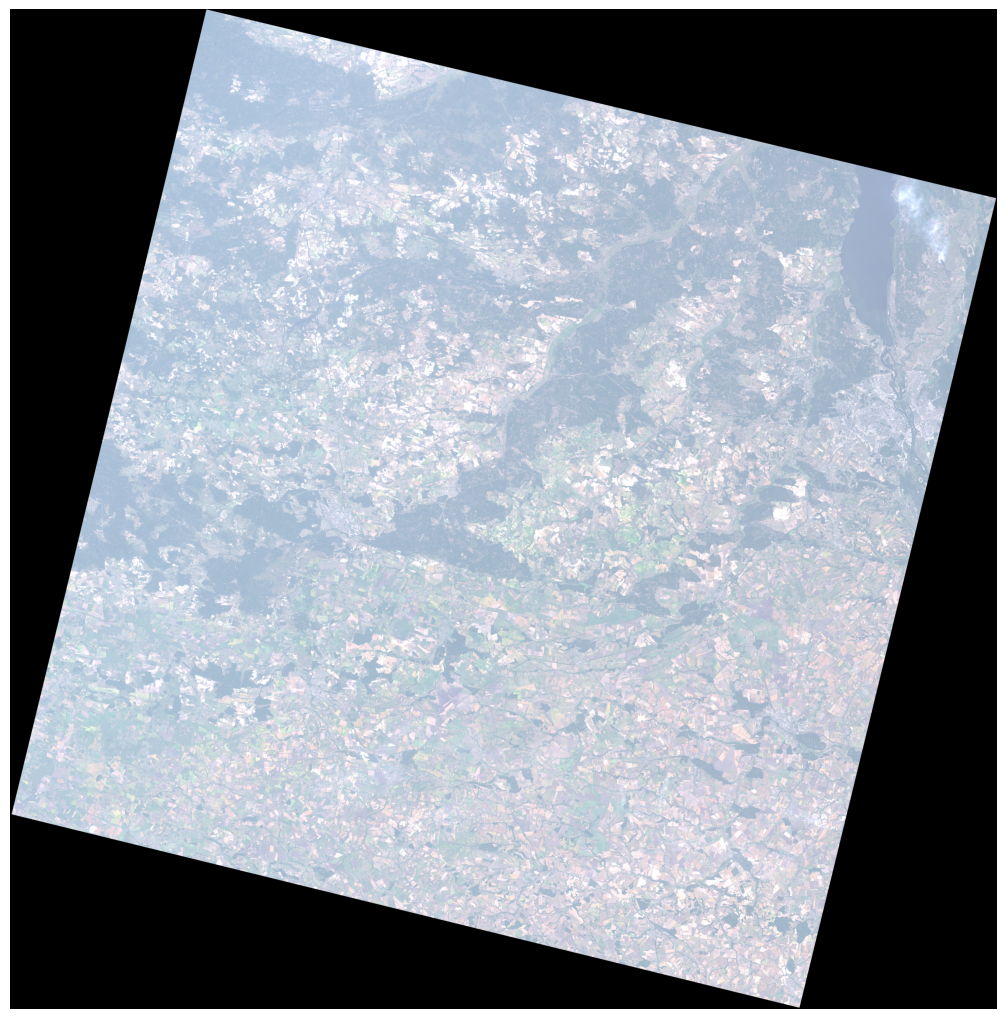

In [18]:
zland = r"C:\Users\blood\OneDrive\Документы\KPI\AD\lab7_parsed\LC08_L1TP_182025_20190830_20200826_02_T1\RGB_30m_ref\rgb_30m_merged.tif"
show_image(zland, rgb_indices=(1, 2, 3))